In [3]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import copy
import pdb

In [4]:
matplotlib.rcParams['figure.figsize'] = [26,8]

#### Model

In [5]:
class RBF(nn.Module):
    def __init__(self):
        '''Implements RBF nonlinearity'''
        super(RBF, self).__init__()
        self.b = 1 # nn.Parameter(torch.ones(1))
        self.c = 0 # nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return torch.exp(- self.b * ((x - self.c)*(x - self.c)))
        
class Exp(nn.Module):
    def __init__(self):
        '''Implements exponential nonlinearity'''
        super(Exp, self).__init__()
        self.lambd = 1
    
    def forward(self, x):
        return self.lambd * torch.exp(- self.lambd * x)

        
class FFNet(nn.Module):
    def __init__(self, layers, nonlinearity='rbf'):
        '''Layers includes first and last layers'''
        super(FFNet, self).__init__()
        
        # Stack neural network layers
        stack = []
        for i in range(len(layers)-1):
            lin = nn.Linear(layers[i], layers[i+1])
            non = Exp() if nonlinearity.lower() == 'exp' else RBF()
            stack = stack + [lin, non] if i != len(layers) - 2 else stack + [lin]
        self.net = nn.Sequential(*stack)
            
    def gaussian_sample_init_(self, m=0, s=1):
        for p in self.parameters():
            p.data.normal_(mean=m, std=s)
        return self
            
    def exponential_sample_init_(self, l=1):
        for p in self.parameters():
            p.data.exponential_(lambd=l)
        return self
            
    def forward(self, x):
        return self.net(x)

#### Sampling from the Prior

In [6]:
# # Architectures to test
# list_of_layers = [[1,10,1],[1,50,1],[1,10,10,1],[1,50,50,1]]
# list_of_priors = ['rbf', 'exp']

# # Range of x values over which to plot
# x_range = torch.arange(-5,5,0.05).reshape(-1,1)

# # Test and plot in grid
# for j, prior in enumerate(list_of_priors):
#   for k, layers in enumerate(list_of_layers):
    
#     # Create model
#     model = FFNet(layers)
    
#     # Set up plotting
#     plt.subplot(len(list_of_priors),len(list_of_layers),j*len(list_of_layers)+k+1)
#     plt.gca().set_title(prior.upper() + ' with shape ' + str(layers))
    
#     # Draw 10 samples
#     for i in range(10):
#       if prior == 'rbf':
#         model.gaussian_sample_init_()
#       elif prior == 'exp':
#         model.exponential_sample_init_()
        
#       # Forward pass
#       y_sampled = model(x_range)
      
#       # Plot
#       x, y = x_range.detach().numpy(), y_sampled.detach().numpy()
#       plt.plot(x,y)

# plt.show()

#### Sampling from the Posterior

/home/luke/miniconda3/envs/py/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type FFNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/luke/miniconda3/envs/py/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RBF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Accepted     24 /     51 (47.1%)
Accepted    593 /   1051 (56.4%)
Accepted   1172 /   2051 (57.1%)
Accepted   1831 /   3051 (60.0%)
Accepted   2215 /   4051 (54.7%)
Accepted   2867 /   5051 (56.8%)
Accepted   3521 /   6051 (58.2%)
Accepted   4307 /   7051 (61.1%)
Accepted   5074 /   8051 (63.0%)
Accepted   5802 /   9051 (64.1%)


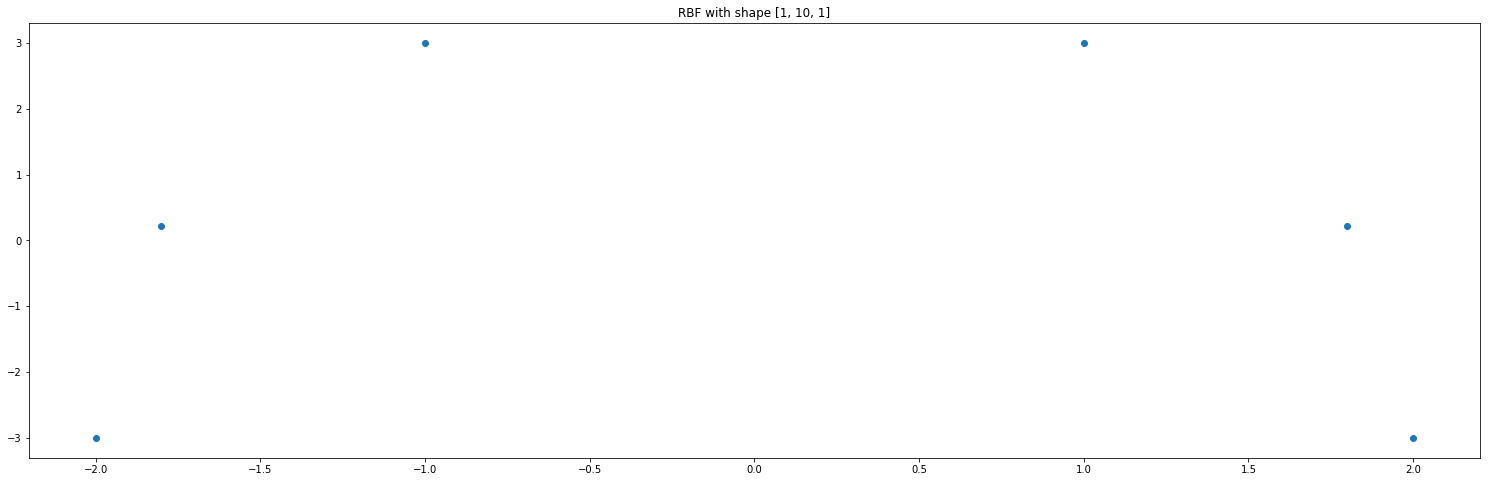

In [122]:
# PyTorch
device = torch.device('cpu')

# Data
X = torch.tensor([-2.0,-1.8,-1.0,1,1.8,2]).reshape(-1,1).to(device)
Y = - X*X*X*X + 3*X*X + 1

# Architectures to test
list_of_layers = [[1,10,1]] #,[1,50,1],[1,10,10,1],[1,50,50,1]]
list_of_priors = ['rbf'] #, 'exp']

# HMC hyperparameters
## FOR 1 LAYER
eps = 1e-2 # epsilon
leapfrog_steps = 20 # L
burnin_samples = 0 # 25000
to_use_samples = 10000

# ## FOR 2 LAYERS
# eps = 2e-3 # epsilon
# leapfrog_steps = 20 # L
# burnin_samples = 25000
# to_use_samples = 1000

# Range of x values over which to plot
x_range = torch.arange(-5,5,0.05).reshape(-1,1).to(device)

def to_numpy(t):
    '''Tensor to numpy'''
    return t.detach().to('cpu').numpy()

def negative_log_probability(model, x=X, y=Y, noise_sigma=0.01, prior_sigma=10.0):
    '''Negative log probability is squared error'''
    y_hat = model(x)
    w_2 = sum(torch.sum(p*p) for p in model.parameters())
    return torch.sum((y_hat - y)*(y_hat - y)) / (2 * noise_sigma) + w_2 / (2 * prior_sigma)

# def negative_log_probability_exp(model, x=X, y=Y, noise_sigma=0.01, prior_sigma=10.0):
#     '''Negative log probability under exponential model'''
#     y_hat = model(x)
#     w_2 = sum(torch.sum(p*p) for p in model.parameters())
#     return torch.sum((y_hat - y)*(y_hat - y)) / (2 * noise_sigma) + w_2 / (2 * prior_sigma)

def hamiltonian_monte_carlo(u, eps, steps, curr_q):
    '''Runs a single step of Hamiltonian Monte Carlo.
         Returns the result of the Metropolis step (accepted/old q)'''

    # Sample momentum 
    curr_p = [torch.randn(q_group.shape).to(device) for q_group in curr_q.parameters()]

    # Copy for comparison in Metropolis step
    q = copy.deepcopy(curr_q)
    p = copy.deepcopy(curr_p)

    # Compute gradients with autodiff
    u(q).backward()
    for q_group, p_group in zip(q.parameters(), p):
        p_group.add_( - eps * q_group.grad / 2 )
    q.zero_grad()

    # Run for L steps
    for i in range(steps):
        # Change q
        for q_group, p_group in zip(q.parameters(), p):
            q_group.data.add_( eps * p_group )
        # Change p
        u(q).backward()
        for q_group, p_group in zip(q.parameters(), p):
            p_group.add_( - eps * q_group.grad / (2.0 if i==steps-1 else 1.0) )
            # if i == 10: print(q_group.grad)
        q.zero_grad()
            
    for p_group in p: 
        p_group.mul_(-1)

    # Calculate energies
    curr_u = u(curr_q)
    curr_k = sum(torch.sum(p_group*p_group) for p_group in curr_p) / 2
    prop_u = u(q)
    prop_k = sum(torch.sum(p_group*p_group) for p_group in p) / 2
    
#     print('{:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(curr_u.item(), curr_k.item(), prop_u.item(), prop_k.item()))
    
    # Accept or reject 
    accept_prob = torch.exp(curr_u - prop_u + curr_k - prop_k).to('cpu')
    if bool(torch.rand(1) < accept_prob):
        return q, 1, curr_u
    else:
        return curr_q, 0, curr_u

# Test and plot in grid
samples = []
for j, prior in enumerate(list_of_priors):
    for k, layers in enumerate(list_of_layers):
        
        # Set up plotting
        plt.subplot(len(list_of_priors),len(list_of_layers),j*len(list_of_layers)+k+1)
        plt.gca().set_title(prior.upper() + ' with shape ' + str(layers))

        # Create potential energy function
        u = negative_log_probability

        # Create model
        curr_q = FFNet(layers).gaussian_sample_init_().to(device)
        
        # Run HMC to collect samples
        samples = []
        total, accepted = 0, 0
#         for i in range(burnin_samples):
#             curr_q, accept = hamiltonian_monte_carlo(u, eps, leapfrog_steps, curr_q)
            
#             # Statistics
#             total += 1
#             accepted += accept
#             if i % 1000 == 100 // 2:
#                 print('Accepted {:6d} / {:6d} ({:.1f}%)'.format(accepted, total, accepted/total*100))

        for i in range(0, to_use_samples):
            curr_q, accept, log_l = hamiltonian_monte_carlo(u, eps, leapfrog_steps, curr_q)
            y_sample = curr_q(x_range)
            
            torch.save(curr_q, './new_wts/curr_q-{}.pth'.format(i))
            torch.save(accept, './new_wts/a-{}.pth'.format(i))
            torch.save(log_l, './new_wts/u-{}.pth'.format(i))
            
            samples.append(y_sample)
            
            total += 1
            accepted += accept
            if i % 1000 == 100 // 2:
                print('Accepted {:6d} / {:6d} ({:.1f}%)'.format(accepted, total, accepted/total*100))

            # plt.plot(to_numpy(x_range),to_numpy(y_sample))

plt.scatter(to_numpy(X), to_numpy(Y))
plt.show()

# torch.save(torch.stack(samples), '1_10_1.pth')

In [0]:
# # Save samples
# torch.save(torch.stack(samples), '1_10_1.pth')

In [0]:
# # Plot
# # fnames = [ ('1_10_1.pth', '[1,10,1]'), ('1_50_1.pth', '[1,50,1]'), ('1_10_10_1.pth', '[1,10,10,1]'), ('1_50_50_1.pth', '[1,50,50,1]') ]

# for i, (fname, name) in enumerate(fnames):
#   samples = torch.load(fname).squeeze().transpose(0,1).detach().cpu().numpy()
#   upper_95 = np.sort(samples, axis=1)[:, 50] 
#   lower_95 = np.sort(samples, axis=1)[:,-50]
  
#   # Plot
#   plt.subplot(2,2,i+1)
#   plt.gca().set_title('BNN with Gaussian prior and network architecture ' + name)
#   plt.gca().fill_between(x_range.reshape(-1), upper_95, lower_95, color="#cccccc")
#   plt.scatter(X, Y, color='black', marker='o')

# plt.show()

#### Diagnostics

In [102]:
import pandas as pd

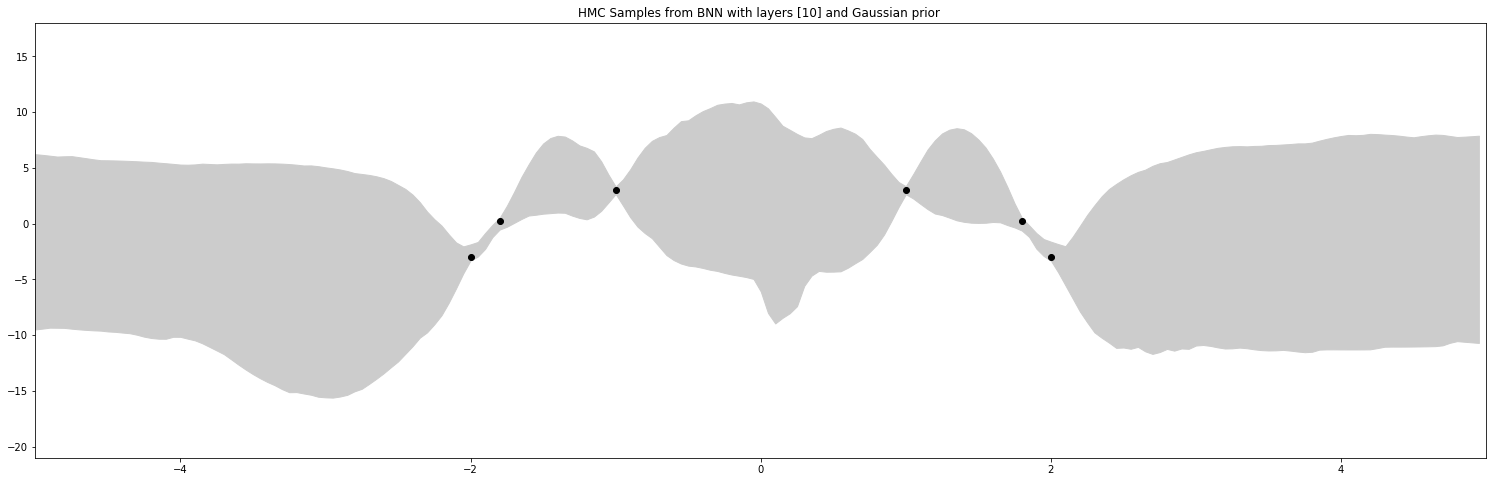

In [103]:
# Confidence interval
bounds = np.sort(to_numpy(torch.cat(samples, dim=1)), axis=1)[:,[5,-5]]
plt.gca().set_title('HMC Samples from BNN with layers [10] and Gaussian prior ')
plt.gca().fill_between(x_range.reshape(-1), bounds[:,1], bounds[:,0], color="#cccccc")
plt.scatter(X, Y, color='black', marker='o')
plt.axis([-5,5,-21,18])
plt.show()

[]

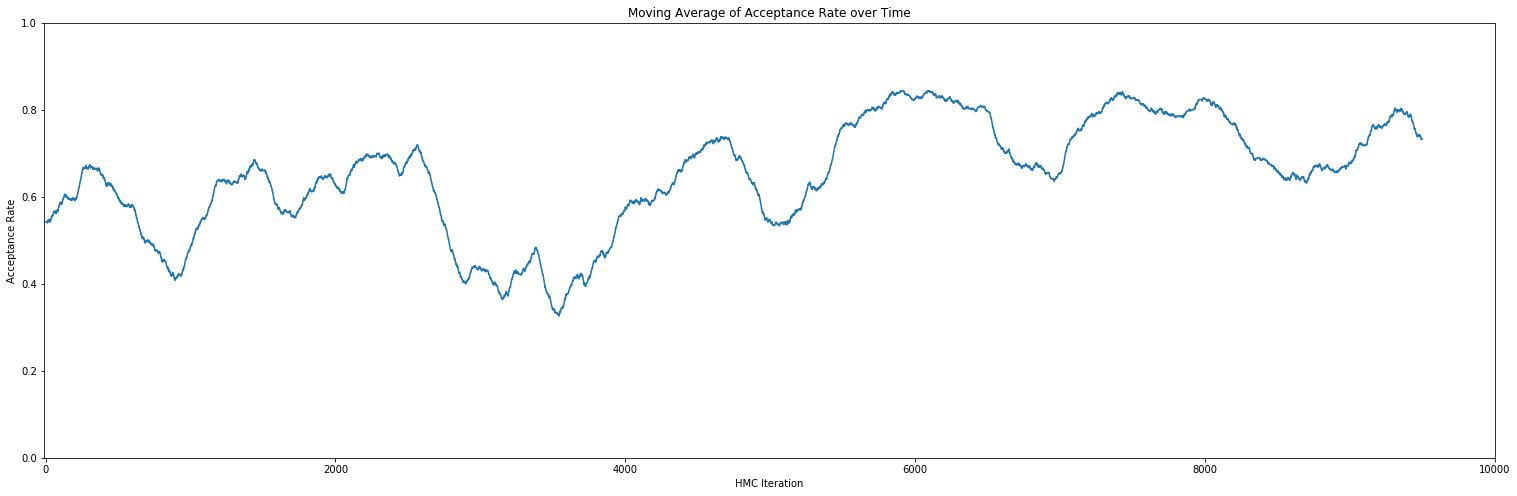

In [124]:
# Acceptance
accepts = []
for i in range(1, 9999):
    accept = torch.load('./new_wts/a-{}.pth'.format(i))    
    accepts.append(accept)
accepts = np.array(accepts)
accepts = np.convolve(accepts, np.ones((500,))/500, mode='valid') # running mean
plt.plot(accepts) 
plt.axis([-10,10000,0,1])
plt.title('Moving Average of Acceptance Rate over Time')
plt.ylabel('Acceptance Rate')
plt.xlabel('HMC Iteration')
plt.plot()

[]

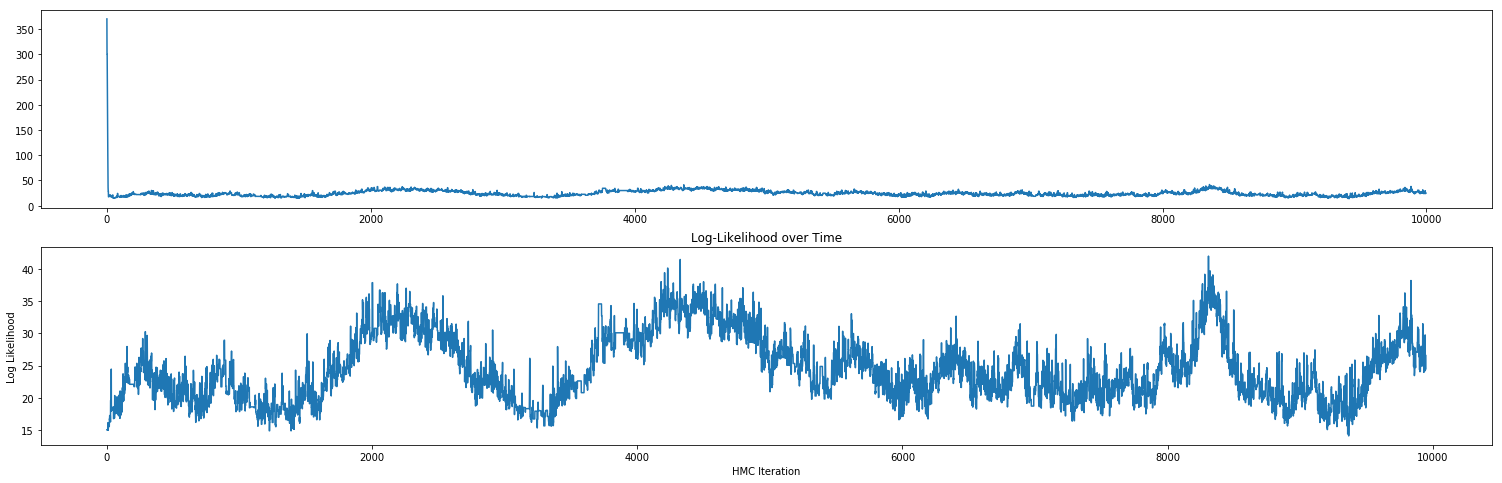

In [123]:
# Acceptance
lls = []
for i in range(1, 9999):
    ll = torch.load('./new_wts/u-{}.pth'.format(i))    
    lls.append(ll.item())
lls = np.array(lls)
plt.subplot(2,1,1)
plt.plot(lls[2:]) 
plt.subplot(2,1,2)
plt.plot(lls[50:]) 
plt.title('Log-Likelihood over Time')
plt.ylabel('Log Likelihood')
plt.xlabel('HMC Iteration')
plt.plot()

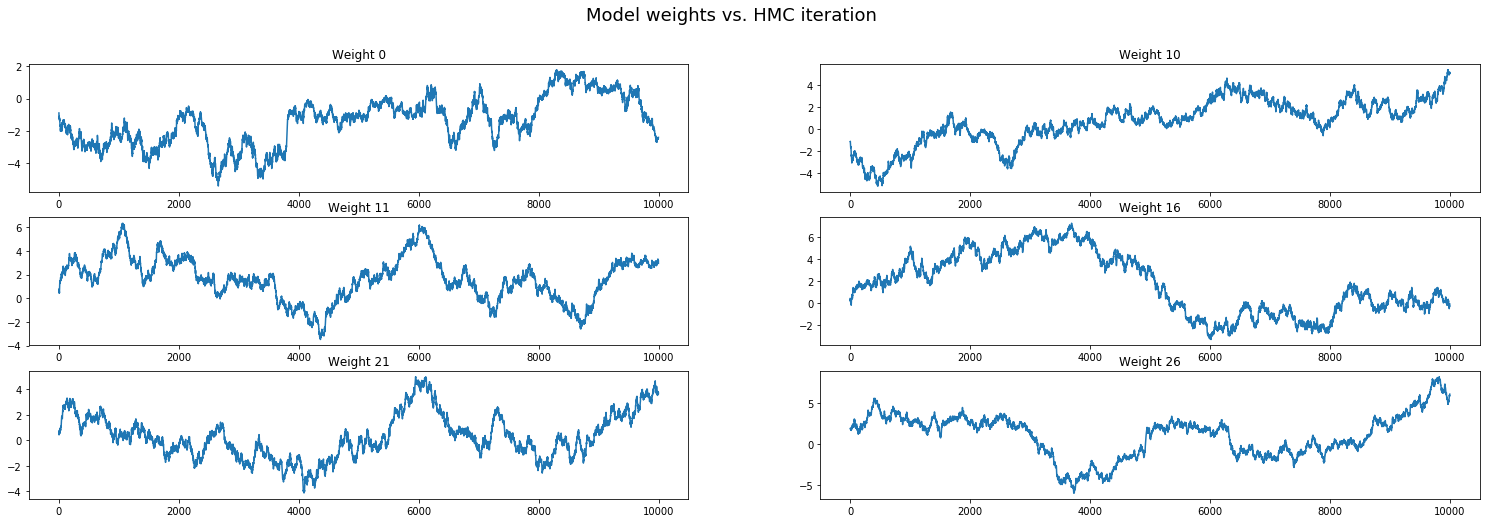

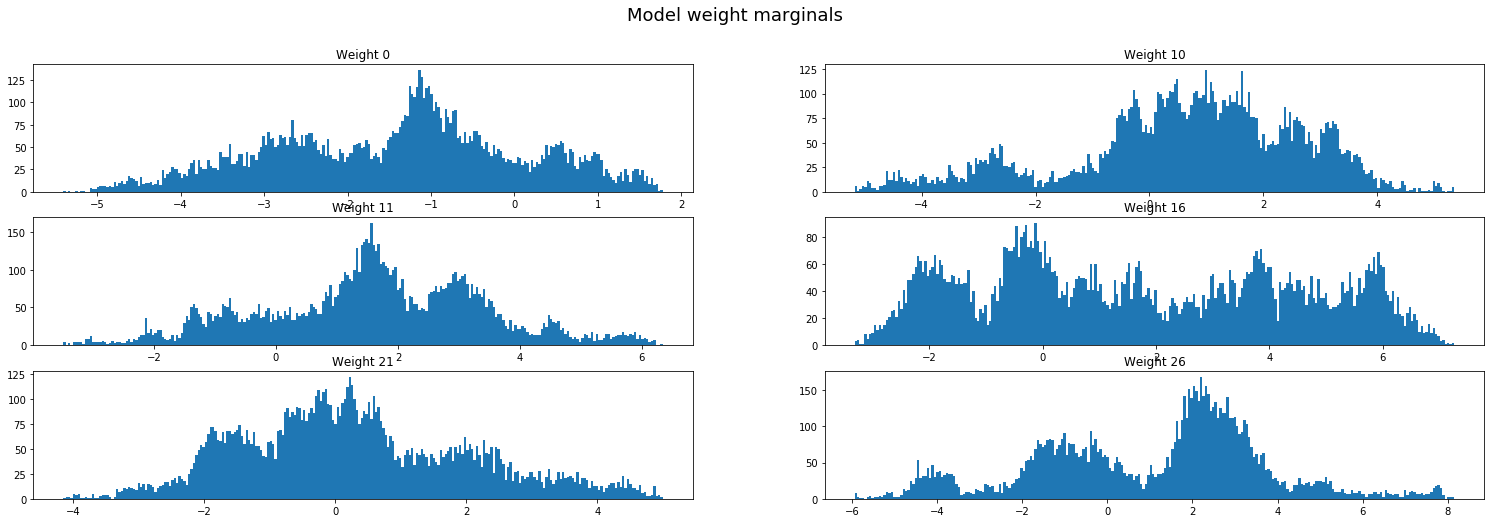

In [114]:
# Load weights
wts = []
for i in range(1, 9999):
    saved_q = torch.load('./new_wts/curr_q-{}.pth'.format(i))
    wts.append([w.item() for ws in saved_q.parameters() for w in ws.reshape(-1)])
wts = np.array(wts)
wts = pd.DataFrame(wts)

# Weights over time
plt.figure()
plt.tight_layout()
plt.suptitle('Model weights vs. HMC iteration', fontsize=18)
for i, w in enumerate([0,10,11,16,21,26]):
    plt.subplot(3,2,i+1)
    plt.title('Weight {}'.format(w))
    plt.plot(wts[w])
plt.show()

# Weight marginals
plt.figure()
plt.tight_layout()
plt.suptitle('Model weight marginals', fontsize=18)
for i, w in enumerate([0,10,11,16,21,26]):
    plt.subplot(3,2,i+1)
    plt.title('Weight {}'.format(w))
    plt.hist(wts[w], bins=250)
plt.show()

/home/luke/miniconda3/envs/py/lib/python3.7/site-packages/matplotlib/pyplot.py:969: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  return gcf().gca(**kwargs)


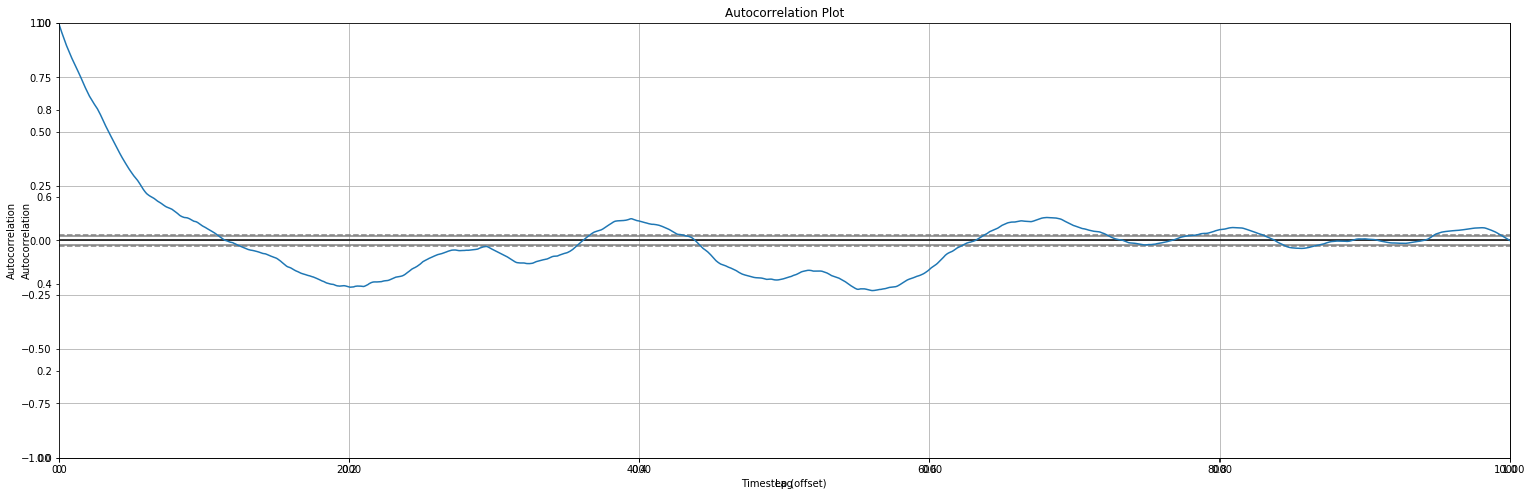

In [115]:
# Autocorrelation plot
plt.title('Autocorrelation Plot')
plt.ylabel('Autocorrelation')
plt.xlabel('Timestep (offset)')
pd.plotting.autocorrelation_plot(wts[5])